In [100]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
#print('OpenCV Version (should be 3.1.0, with nonfree packages installed, for this tutorial):')
print(cv2.__version__)
import PIL
from PIL import Image, ImageOps
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.base import BaseEstimator, TransformerMixin
#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

3.3.1


# Some links...

https://www.pyimagesearch.com/2014/05/26/opencv-python-k-means-color-clustering/  
http://charlesleifer.com/blog/using-python-and-k-means-to-find-the-dominant-colors-in-images/  
https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_ml/py_kmeans/py_kmeans_opencv/py_kmeans_opencv.html

# Dataset loading

In [2]:
dataset = pd.read_csv('Z1-picture_cropping.csv', index_col=0, dtype={'foldername':'object'})
dataset.head()

,breed,file,xmin,ymin,xmax,ymax,foldername,filename,dog_number,prepfilename,xdelta,ydelta
n02085620_10074,Chihuahua,n02085620_10074,25.0,10.0,276.0,498.0,02085620,n02085620_10074,1,n02085620_10074-Chihuahua_cr1,251.0,488.0
n02085620_10131,Chihuahua,n02085620_10131,49.0,9.0,393.0,493.0,02085620,n02085620_10131,1,n02085620_10131-Chihuahua_cr1,344.0,484.0
n02085620_10621,Chihuahua,n02085620_10621,142.0,43.0,335.0,250.0,02085620,n02085620_10621,1,n02085620_10621-Chihuahua_cr1,193.0,207.0
n02085620_1073,Chihuahua,n02085620_1073,0.0,27.0,312.0,498.0,02085620,n02085620_1073,1,n02085620_1073-Chihuahua_cr1,312.0,471.0
n02085620_10976,Chihuahua,n02085620_10976,90.0,104.0,242.0,452.0,02085620,n02085620_10976,1,n02085620_10976-Chihuahua_cr1,152.0,348.0


In [3]:
le = preprocessing.LabelEncoder()
le.fit(dataset['breed'])
print(le.classes_)
dataset['breed_code'] = le.transform(dataset['breed'])
dataset.head()

['Afghan_hound' 'African_hunting_dog' 'Airedale'
 'American_Staffordshire_terrier' 'Appenzeller' 'Australian_terrier'
 'Bedlington_terrier' 'Bernese_mountain_dog' 'Blenheim_spaniel'
 'Border_collie' 'Border_terrier' 'Boston_bull' 'Bouvier_des_Flandres'
 'Brabancon_griffon' 'Brittany_spaniel' 'Cardigan'
 'Chesapeake_Bay_retriever' 'Chihuahua' 'Dandie_Dinmont' 'Doberman'
 'English_foxhound' 'English_setter' 'English_springer' 'EntleBucher'
 'Eskimo_dog' 'French_bulldog' 'German_shepherd'
 'German_short-haired_pointer' 'Gordon_setter' 'Great_Dane'
 'Great_Pyrenees' 'Greater_Swiss_Mountain_dog' 'Ibizan_hound'
 'Irish_setter' 'Irish_terrier' 'Irish_water_spaniel' 'Irish_wolfhound'
 'Italian_greyhound' 'Japanese_spaniel' 'Kerry_blue_terrier'
 'Labrador_retriever' 'Lakeland_terrier' 'Leonberg' 'Lhasa' 'Maltese_dog'
 'Mexican_hairless' 'Newfoundland' 'Norfolk_terrier' 'Norwegian_elkhound'
 'Norwich_terrier' 'Old_English_sheepdog' 'Pekinese' 'Pembroke'
 'Pomeranian' 'Rhodesian_ridgeback' 'Rottw

,breed,file,xmin,ymin,xmax,ymax,foldername,filename,dog_number,prepfilename,xdelta,ydelta,breed_code
n02085620_10074,Chihuahua,n02085620_10074,25.0,10.0,276.0,498.0,02085620,n02085620_10074,1,n02085620_10074-Chihuahua_cr1,251.0,488.0,17
n02085620_10131,Chihuahua,n02085620_10131,49.0,9.0,393.0,493.0,02085620,n02085620_10131,1,n02085620_10131-Chihuahua_cr1,344.0,484.0,17
n02085620_10621,Chihuahua,n02085620_10621,142.0,43.0,335.0,250.0,02085620,n02085620_10621,1,n02085620_10621-Chihuahua_cr1,193.0,207.0,17
n02085620_1073,Chihuahua,n02085620_1073,0.0,27.0,312.0,498.0,02085620,n02085620_1073,1,n02085620_1073-Chihuahua_cr1,312.0,471.0,17
n02085620_10976,Chihuahua,n02085620_10976,90.0,104.0,242.0,452.0,02085620,n02085620_10976,1,n02085620_10976-Chihuahua_cr1,152.0,348.0,17


In [4]:
subset = dataset[dataset['breed_code'] < 4]
subset.shape

(774, 13)

In [5]:
subset.head()

,breed,file,xmin,ymin,xmax,ymax,foldername,filename,dog_number,prepfilename,xdelta,ydelta,breed_code
n02088094_1003,Afghan_hound,n02088094_1003,45.0,43.0,289.0,490.0,02088094,n02088094_1003,1,n02088094_1003-Afghan_hound_cr1,244.0,447.0,0
n02088094_1007,Afghan_hound,n02088094_1007,236.0,80.0,447.0,332.0,02088094,n02088094_1007,1,n02088094_1007-Afghan_hound_cr1,211.0,252.0,0
n02088094_1023,Afghan_hound,n02088094_1023,174.0,214.0,267.0,382.0,02088094,n02088094_1023,2,n02088094_1023-Afghan_hound_cr2,93.0,168.0,0
n02088094_10263,Afghan_hound,n02088094_10263,11.0,115.0,355.0,423.0,02088094,n02088094_10263,1,n02088094_10263-Afghan_hound_cr1,344.0,308.0,0
n02088094_10715,Afghan_hound,n02088094_10715,31.0,43.0,290.0,483.0,02088094,n02088094_10715,1,n02088094_10715-Afghan_hound_cr1,259.0,440.0,0


In [6]:
X_train, X_test, y_train, y_test = train_test_split(subset, subset['breed_code'], test_size=0.33, random_state=0, stratify=subset['breed_code'])

# Class creation

In [118]:
class SiftBOW(BaseEstimator, TransformerMixin):

    def __init__(self, estimator, **params):        
        self.kmeans_params = {'n_clusters':30, 'verbose':0, 'random_state':3, 'max_iter': 300}
        self.sift_params = {'nfeatures':0}
        self.estimator_params = {'max_depth':None, 'random_state':0, 'verbose':0, 'n_estimators':10}
        self.pca_params = {'n_components':10, 'random_state':0}
        self.cvect_params = {'ngram_range':(1,1), 'min_df':1, 'max_df':1.}
        self.color_params = {'n_clusters':30, 'random_state':0}
        self.pics_params = {'save_pics':True, 'equalyze':True, }
        
        self.clf_params = {'trained':False, 'kmean_sample_size':10000}
        
        self.params = {**{'kmeans_'+k:v for k,v in self.kmeans_params.items()},
                       **{'sift_'+k:v for k,v in self.sift_params.items()},
                       **{'estimator_'+k:v for k,v in self.estimator_params.items()},
                       **{'cvect_'+k:v for k,v in self.cvect_params.items()},
                       **{'clf_'+k:v for k,v in self.clf_params.items()},
                       **{'pca_'+k:v for k,v in self.pca_params.items()},
                       **{'color_'+k:v for k,v in self.color_params.items()},
                       **{'pics_'+k:v for k,v in self.pics_params.items()},
                       **params}
        
        self.update_params()
        
        self.estimator = estimator
        self.estimator.set_params(**self.estimator_params)
        self.kmeans = KMeans(**self.kmeans_params)
        self.scaler = StandardScaler()
        self.color_scaler = StandardScaler()
        self.cvect = CountVectorizer(**self.cvect_params, analyzer='word', tokenizer=None)
        self.sift = cv2.xfeatures2d.SIFT_create(**self.sift_params)
        self.pca = PCA(**self.pca_params)
        self.color_kmeans = KMeans(**self.color_params)
        
    def get_params(self, deep=True):
        return self.params
    
    def set_params(self, **params):
        self.params = {**self.params, **params}
        self.update_params()
        return self
        
    def update_params(self):
        
        self.kmeans_params = {k[7:]:v for k,v in self.params.items() if k.startswith('kmeans_')}
        self.sift_params = {k[5:]:v for k,v in self.params.items() if k.startswith('sift_')}
        self.estimator_params = {k[10:]:v for k,v in self.params.items() if k.startswith('estimator_')}
        self.pics_params = {k[5:]:v for k,v in self.params.items() if k.startswith('pics_')}
        self.color_params = {k[6:]:v for k,v in self.params.items() if k.startswith('color_')}
        
        self.cvect_params = {k[6:]:v for k,v in self.params.items() if k.startswith('cvect_')}
        self.pca_params = {k[4:]:v for k,v in self.params.items() if k.startswith('pca_')}
        self.clf_params = {k[4:]:v for k,v in self.params.items() if k.startswith('clf_')}

        return self

    def get_feature_importances_(self):
        pass
    
    def score(self, X, y):
        pics, sift_desc , colors = self.transform(X)
        bow = self.compute_data(sift_desc , colors)
        Xbow = self.transform_bow(bow)
        
        return self.estimator.score(Xbow, y)
    
    def fit_bow(self, keydescriptors):
        self.cvect.fit(keydescriptors)
        print('BOW fitted')
        return self
    
    def fit_colors(self, colors, samplesize=10000):
        colorlist = colors.reshape(-1,3)
        indices = np.random.randint(0, colorlist.shape[0], samplesize)
        Xsample = colors[indices]
        Xscaled = self.color_scaler.fit_transform(Xsample)
        self.color_kmeans.fit(Xscaled)
        print('Color dominance fitted')
        return self
    
    def transform_bow(self, keydescriptors):
        return self.cvect.transform(keydescriptors)
    
    def fit(self, X, y):
        pics, sift_desc, color_dominance = self.transform(X, y)
        self.fit_sift(np.concatenate(sift_desc))
        self.fit_colors(np.concatenate(color_dominance))
        
        bow = self.compute_data(sift_desc, color_dominance)
        self.fit_bow(bow)
        Xbow = self.transform_bow(bow)
        self.estimator.fit(Xbow, y)
        trainingscore = self.estimator.score(Xbow, y)
        print('Training score', trainingscore)
        self.clf_params['trained'] = True
        return Xbow
    
    def color_domincance(self, picture, n_cluster=10):
        #Converts to openCV
        imcv = cv2.cvtColor(np.array(picture), cv2.COLOR_RGB2BGR)
        
        #Flatten all the pixels
        Z = imcv.reshape((-1,3))

        # convert to np.float32
        Z = np.float32(Z)

        # define criteria, number of clusters(K) and apply kmeans()
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        K = n_cluster
        ret, label, color_dominance = cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
        return color_dominance
    
    def transform(self, X, y=None):
        sift_desc = []
        colors = []
        pics = []
        filenames = []
        for index, picture in X.iterrows():
            xmax = picture.xmax
            ymax = picture.ymax
            xmin = picture.xmin
            ymin = picture.ymin
            foldername = picture.foldername
            breed = picture.breed
            filename = picture.filename
            prepfilename = picture.prepfilename
        
            filenames.append(prepfilename)
        
            #Image opening
            img = Image.open('../Images/n{}-{}/{}.jpg'.format(foldername, breed, filename))
            
            color_dominance = self.color_domincance(img)
            
            #Image cropping
            area = (xmin, ymin, xmax, ymax)
            img = img.crop(area)

#            #Image greyscale
#            img = ImageOps.grayscale(img)
            
            #Image equalization
            img = ImageOps.equalize(img)

            temp_img, temp_sift, temp_color = self.treat_pictures(img, prepfilename)
            colors.append(temp_color)
            pics.append(temp_img)
            sift_desc.append(temp_sift)
        
        print('Pictures loaded')
        
        return pics, sift_desc, colors
    
    def predict(self, X, y):
        pics, sift_desc, colors = self.transform(X, y)
        bow = self.compute_data(sift_desc, colors)
        Xbow = self.transform_bow(bow)
        
        return self.estimator.predict(Xbow)
    
    def fit_sift(self, descriptors):
        indices = np.random.randint(0,descriptors.shape[0],self.clf_params['kmean_sample_size'])
        Xsample = descriptors[indices]
        Xscaled = self.scaler.fit_transform(Xsample)
        if self.clf_params['apply_pca']:
            Xscaled = self.pca.fit_transform(Xscaled)
            print('PCA fitted')
        else:
            print('No PCA')
        self.kmeans.fit(Xscaled)
        print('Sift fitted')
        return self
    
    def compute_data(self, descriptors, colors):
        toreturn = []
        for descriptor , color in zip(descriptors, colors):
            #Key points treatment
            XScaled = self.scaler.transform(descriptor)
            if self.clf_params['apply_pca']:
                XScaled = self.pca.transform(XScaled)
            bow_keys = [self.kmeans.predict(keydescription.reshape(1, -1))[0] for keydescription in XScaled]
            keystring = ' '.join(['kp'+str(x) for x in bow_keys])
            
            #Colors treatment
            XScaled = self.color_scaler.transform(color)
            bow_colors = [self.color_kmeans.predict(majorcolor.reshape(1, -1))[0] for majorcolor in XScaled]
            colorstring = ' '.join(['cl'+str(x) for x in bow_colors])
            
            toreturn.append(keystring+' '+colorstring) #
        return toreturn
    
    def exportset(self, X):
        pics, sift_desc, colors = self.transform(X)
        bow = self.compute_data(sift_desc, colors)
        Xbow = self.transform_bow(bow)
        return Xbow
    
    def treat_pictures(self, picture, prepfilename='zzz'):

        color_dominance = self.color_domincance(picture)
        imcv = cv2.cvtColor(np.array(picture), cv2.COLOR_RGB2BGR)
        imcv_gr = cv2.cvtColor(imcv, cv2.IMREAD_GRAYSCALE)
        
        #plt.imshow(cv2.cvtColor(imcv, cv2.CV_32S))
        #plt.show()
        
        imcv_kp, imcv_desc = self.sift.detectAndCompute(imcv_gr, None)

        if self.pics_params['save_pics']:
            #Image saving OpenCV
            cv2.imwrite('../pics/{}.jpg'.format(prepfilename),cv2.drawKeypoints(imcv, imcv_kp, imcv.copy()))
        
        return picture, imcv_desc, color_dominance

clf = RandomForestClassifier()
dogreconizer = SiftBOW(clf, **{'pics_save_pics':True, 'clf_apply_pca':False})
dogreconizer.get_params()
dogreconizer.fit(X_train[:3], y_train[:3])

Pictures loaded
No PCA
Sift fitted
Color dominance fitted
BOW fitted
Training score 1.0


<3x60 sparse matrix of type '<class 'numpy.int64'>'
	with 120 stored elements in Compressed Sparse Row format>

In [58]:
clf = RandomForestClassifier()
dogreconizer = SiftBOW(clf, **{'pics_save_pics':True, 'clf_apply_pca':False})

In [83]:
XX_train = dogreconizer.fit(X_train, y_train)

Pictures loaded
No PCA
Sift fitted
Color dominance fitted
BOW fitted
Training score 0.9903474903474904


In [60]:
y_pred = dogreconizer.predict(X_test, y_test)
y_pred

Pictures loaded


array([1, 0, 0, 2, 1, 3, 0, 1, 0, 0, 0, 0, 2, 2, 1, 1, 2, 0, 0, 2, 0, 2,
       0, 3, 2, 0, 2, 2, 2, 3, 0, 1, 0, 3, 2, 1, 0, 1, 2, 0, 2, 1, 0, 3,
       3, 1, 0, 2, 0, 0, 2, 0, 1, 3, 2, 1, 0, 2, 2, 0, 1, 0, 0, 3, 1, 0,
       2, 1, 0, 1, 3, 1, 0, 1, 0, 3, 0, 3, 3, 3, 0, 3, 3, 0, 0, 0, 3, 0,
       2, 2, 2, 2, 2, 0, 1, 3, 1, 1, 0, 0, 3, 1, 3, 2, 0, 2, 1, 1, 0, 0,
       1, 0, 2, 0, 2, 1, 2, 0, 2, 0, 3, 3, 0, 0, 3, 1, 1, 0, 0, 0, 3, 3,
       0, 2, 2, 0, 0, 0, 0, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 3, 2, 0, 2, 2,
       2, 2, 3, 0, 0, 2, 2, 3, 3, 0, 0, 1, 2, 0, 2, 2, 3, 1, 1, 1, 2, 0,
       0, 1, 2, 2, 0, 0, 3, 0, 1, 0, 2, 2, 2, 0, 0, 0, 1, 2, 0, 3, 2, 2,
       0, 2, 0, 3, 0, 0, 1, 2, 1, 0, 1, 1, 0, 3, 0, 2, 0, 3, 0, 1, 1, 2,
       3, 1, 2, 0, 0, 2, 2, 0, 1, 1, 2, 2, 0, 0, 1, 0, 0, 1, 3, 1, 1, 0,
       1, 0, 3, 0, 1, 0, 2, 2, 0, 1, 0, 2, 2, 1])

In [61]:
confusion_matrix(y_test, y_pred)


array([[53, 10,  7,  9],
       [12, 28, 13,  3],
       [14, 10, 36,  7],
       [15, 12,  9, 18]])

In [62]:
dogreconizer.score(X_test, y_test)

Pictures loaded


0.54296875

In [84]:
XX_test = dogreconizer.exportset(X_test)

Pictures loaded


In [23]:
X_train.shape

(518, 13)

# KNeighborsClassifier

In [88]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=12, n_jobs=3)
neigh.fit(XX_train.toarray(), y_train.values)
neigh.score(XX_test.toarray(), y_test.values)

0.55859375

In [102]:
parameters = {'n_neighbors':[3,5,7,9,15,20], 'leaf_size': [10,20,30,40,50]}
scorer = make_scorer(f1_score, average='micro')

clfknn = GridSearchCV(neigh, parameters, verbose=1, cv=3, n_jobs=5, scoring=scorer)
clfknn.fit(XX_train.toarray(), y_train.values)
clfknn.score(XX_test.toarray(), y_test.values)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    3.9s finished


0.56640625

# SVC

In [89]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(XX_train.toarray(), y_train.values)
clf.score(XX_test.toarray(), y_test.values)

0.30859375

In [101]:
parameters = {'C':np.logspace(-5, 5, 11), 'gamma':np.logspace(-5, 5, 11)}
scorer = make_scorer(f1_score, average='micro')

clfsvc = GridSearchCV(clf, parameters, verbose=1, cv=3, n_jobs=5, scoring=scorer)
clfsvc.fit(XX_train.toarray(), y_train.values)
clfsvc.score(XX_test.toarray(), y_test.values)

Fitting 3 folds for each of 121 candidates, totalling 363 fits


[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 363 out of 363 | elapsed:    3.5s finished


0.66015625

In [97]:
clfsvc.best_params_

{'C': 31.622776601683793, 'gamma': 1e-05}

# Random Forrest

In [103]:
clf = RandomForestClassifier(random_state=0)

In [105]:
parameters = {'n_estimators':[10,50,100,500],
              'max_depth':[None,10,15,20],
              'min_samples_split':[2,3,5],}
scorer = make_scorer(f1_score, average='micro')

clfrfc = GridSearchCV(clf, parameters, verbose=1, cv=5, n_jobs=3, scoring=scorer)
clfrfc.fit(XX_train.toarray(), y_train.values)
clfrfc.score(XX_test.toarray(), y_test.values)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=3)]: Done 110 tasks      | elapsed:   13.4s
[Parallel(n_jobs=3)]: Done 240 out of 240 | elapsed:   31.3s finished


0.60546875

In [108]:
clfrfc.best_params_

{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}

In [117]:
clf = RandomForestClassifier(random_state=0, **clfrfc.best_params_)
clf.fit(XX_train.toarray(), y_train.values)
clf.feature_importances_




array([0.0063605 , 0.00868034, 0.0040952 , 0.00629071, 0.00633876,
       0.00349886, 0.00558821, 0.00490639, 0.00813842, 0.00320802,
       0.00168273, 0.00488969, 0.00087108, 0.00090622, 0.00407985,
       0.00444978, 0.0110547 , 0.00542311, 0.00236389, 0.0052936 ,
       0.00319175, 0.00208255, 0.00433431, 0.0067357 , 0.00616975,
       0.00106261, 0.00650464, 0.00500105, 0.00220205, 0.00291759,
       0.03062906, 0.02213617, 0.03246236, 0.02325279, 0.03313535,
       0.04250873, 0.02656952, 0.02528625, 0.03620736, 0.02846499,
       0.0367549 , 0.02806883, 0.02492078, 0.01991885, 0.02716017,
       0.03276097, 0.02239816, 0.02538317, 0.02932026, 0.02349456,
       0.01976998, 0.03567668, 0.03953854, 0.03207228, 0.03894835,
       0.02169546, 0.02644777, 0.0232633 , 0.02352138, 0.02991099])

# GradientBoostingClassifier

In [109]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()

In [110]:
parameters = {'n_estimators':[10,50,100,500],
              'max_depth':[None,10,15,20],
              'min_samples_split':[2,3,5],}
scorer = make_scorer(f1_score, average='micro')

clfgbc = GridSearchCV(clf, parameters, verbose=1, cv=5, n_jobs=3, scoring=scorer)
clfgbc.fit(XX_train.toarray(), y_train.values)
clfgbc.score(XX_test.toarray(), y_test.values)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   27.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.2min
[Parallel(n_jobs=3)]: Done 240 out of 240 | elapsed:  2.9min finished


0.51953125

In [111]:
clfgbc.best_params_

{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 500}

In [114]:
clf = GradientBoostingClassifier(**clfgbc.best_params_)
clf.fit(XX_train.toarray(), y_train.values)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

/Users/cricket/anaconda3/lib/python3.6/site-packages/keras/preprocessing/image.py:492: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


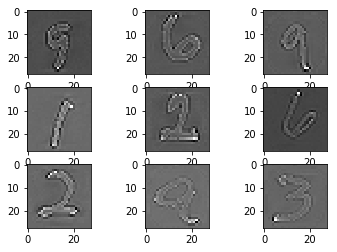

In [49]:
# ZCA whitening
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from keras import backend as K
K.set_image_dim_ordering('th')
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
# convert from int to float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# define data preparation
datagen = ImageDataGenerator(zca_whitening=True)
# fit parameters from data
datagen.fit(X_train)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    # create a grid of 3x3 images
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(X_batch[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
    # show the plot
    pyplot.show()
    break

In [53]:
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train.shape

(60000, 28, 28)

In [ ]:
plt.imshow(X_train[1].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
plt.show()

In [ ]:
X_train[0][0]